# Importing

In [365]:
import numpy as np
import pickle
from numba import njit
import time
import os

import matplotlib.pyplot as plt
%matplotlib widget

# Getting Data:

In [366]:
n  = 6  # Number of nearest neighbors
Nc = 40 # Number of children

CWD = os.getcwd()

# 1D Data:
with open(f'{CWD}/FMs.pck', 'rb') as f:
    FM = pickle.load(f)
with open(f'{CWD}/genomes.pck', 'rb') as f:
    G  = pickle.load(f)

# 2D Data:
# with open(f'{CWD}/FM2d.pck', 'rb') as f:
#     FM = pickle.load(f)
# with open(f'{CWD}/genomes2d.pck', 'rb') as f:
#     G  = pickle.load(f)

num_sets = len(G)
FM_size = FM[0].shape[0]

FM = np.array(FM)
G  = np.array(G).reshape((num_sets,FM_size,-1))

permutation = np.random.permutation(G.shape[0])

Gc  =  G[permutation[:Nc],:,:]
FMc = FM[permutation[:Nc],:,:]
Gs  =  G[permutation[Nc:],:,:]
FMs = FM[permutation[Nc:],:,:]

# print(G.shape)
# print(FM.shape)

# Source/Destination Relationship

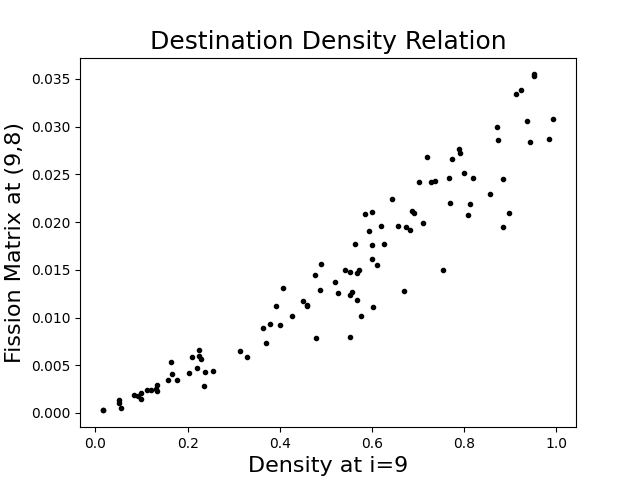

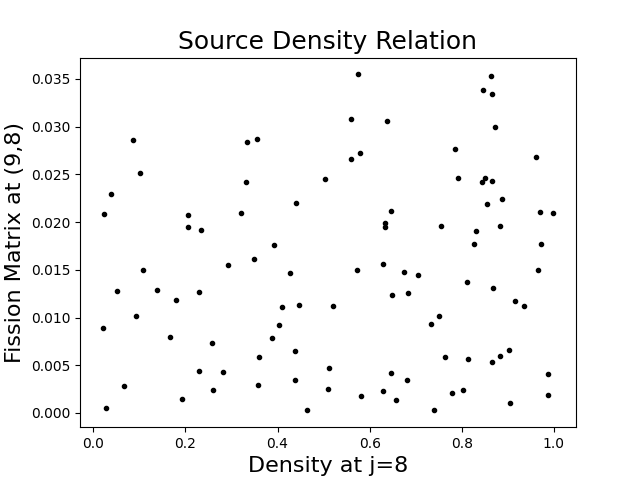

In [367]:
IJ = (9,8)



Gi = [g[IJ[0]] for g in G]
Gj = [g[IJ[1]] for g in G]
FMij = [fm[IJ[0],IJ[1]] for fm in FM]

plt.figure(1)
plt.clf()
plt.plot(Gi, FMij, '.k')
plt.xlabel(f'Density at i={IJ[0]}', fontsize=16)
plt.ylabel(f'Fission Matrix at ({IJ[0]},{IJ[1]})', fontsize=16)
plt.title(f'Destination Density Relation', fontsize=18)
plt.show()

plt.figure(2)
plt.clf()
plt.plot(Gj, FMij, '.k')
plt.xlabel(f'Density at j={IJ[1]}', fontsize=16)
plt.ylabel(f'Fission Matrix at ({IJ[0]},{IJ[1]})', fontsize=16)
plt.title(f'Source Density Relation', fontsize=18)
plt.show()

# Performance For Various Cases:

Time 2 = 0.94552 s
Time 3 = 0.74088 s
Time 4 = 0.79424 s
Time 5 = 0.80207 s
Time 6 = 0.78653 s


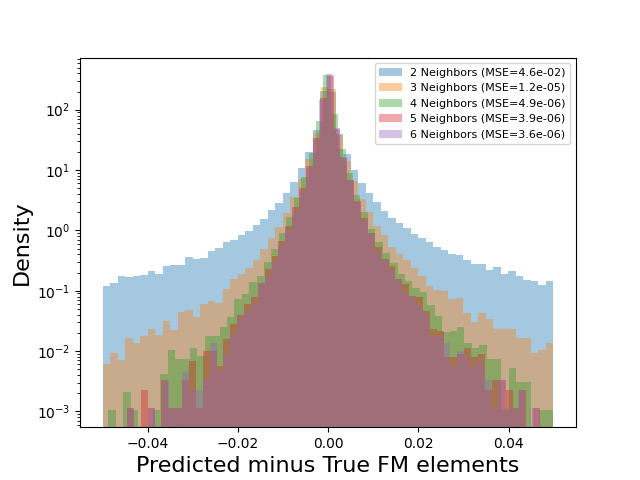

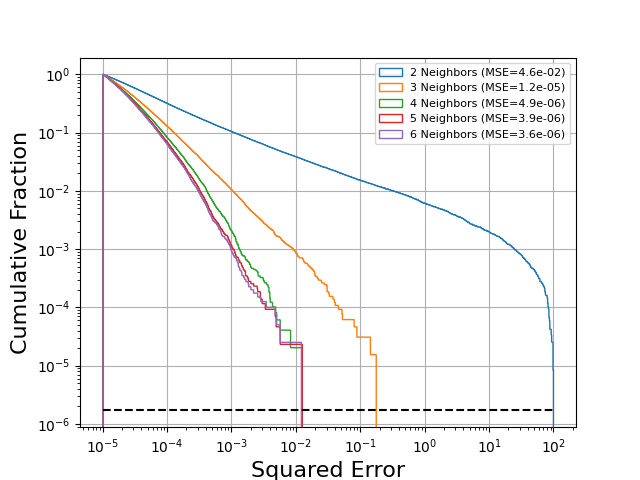

In [368]:
nbins = 60

def find_nearest_neighbors(genome_children, genomes, FMs, n:int=3):
    """
    Finds the nearest genomes and respective FM matrices.

    * INPUTS:
    genome_children : children genome array
    genomes         : evaluated genome array
    FMs             : evaluated fission matrix Array
    n               : number of nearest neighbors to find

    * RETURNS:
    genome_neighbors : n nearest neighbors of the child genome array
    FM_neighbors     : n nearest neighbors of the parent genome array

    * NOTES:
    The dimensions of the input and output variables are as follows:

    genome_children index 0 : child genome reference index
    genome_children index 1 : spatial cell index
    genome_children index 2 : genome in spatial cell (i.e. UO2 density=0, Pu density=1)

    genomes index 0 : evaluated genome reference index
    genomes index 1 : spatial cell index
    genomes index 2 : genome in spatial cell (i.e. UO2 density=0, Pu density=1)

    FMs index 0 : evaluated fission matrix reference index
    FMs index 1 : destination spatial cell index
    FMs index 2 : source spatial cell index

    genome_neighbors index 0 : child genome reference index
    genome_neighbors index 1 : spatial cell index
    genome_neighbors index 2 : i-th nearest neighbor
    genome_neighbors index 3 : genome in spatial cell (i.e. UO2 density=0, Pu density=1)

    FM_neighbors index 0 : child genome reference index
    FM_neighbors index 1 : destination spatial cell index
    FM_neighbors index 2 : source spatial cell index
    FM_neighbors index 3 : i-th nearest neighbor
    """

    def find_nearest_individual(genome_child):
        indices = np.argsort([np.linalg.norm(genome-genome_child) for genome in genomes])[:n]
        genome_neighbors  =  genomes[indices,:,:]
        FM_neighbors = FMs[indices,:,:]
        return genome_neighbors, FM_neighbors

    neighbor_set = [find_nearest_individual(genome_child) for genome_child in genome_children]
    genome_neighbors, FM_neighbors = tuple([list(el) for el in zip(*neighbor_set)])
    genome_neighbors = np.array(genome_neighbors).transpose((0,2,1,3))
    FM_neighbors = np.array(FM_neighbors).transpose((0,2,3,1))
    return genome_neighbors, FM_neighbors

def EstimateFM(Gc, Gn, FMn):
    """
    Estimates the FM matrix with a linear regression with the nearest genomes.

    * INPUTS:
    Gc  : child genome array
    Gn  : nearest neighbor genome array
    FMn : nearest neighbor Fission Matrix array

    * RETURNS:
    FMc : child Fission Matrix array
    
    * NOTES:
    The linear regression is highly parallelizable, so we can perform all FM
    estimates for all children in parallel. The dimensions of the input and
    output variables are as follows:

    Gn index 0 : child number that needs a FM estimate
    Gn index 1 : spatial cell index
    Gn index 2 : i-th nearest neighbor
    Gn index 3 : genome in spatial cell (i.e. UO2 density=0, Pu density=1)

    FMn index 0 : child number that needs a FM estimate
    FMn index 1 : destination spatial cell index
    FMn index 2 : source spatial cell index
    FMn index 3 : i-th nearest neighbor 

    Gc index 0 : child number that needs a FM estimate
    Gc index 1 : spatial cell index
    Gc index 2 : genome in spatial cell (i.e. UO2 density=0, Pu density=1)

    FMc index 0 : child number that needs a FM estimate
    FMc index 1 : destination spatial cell index
    FMc index 2 : source spatial cell index
    """

    n = Gn.shape[2] # Number of nearest neighbors
    k = Gn.shape[3] # Number of genomes per spatial cell
    if n < k + 1: # Just take the nearest FM as a guess
        raise ValueError(f'WARNING: you need {k+1} nearest neighbors to perform a regression over {k} genomes per spatial cell.')

    # Neighbor Genome Preparation:
    Xn  = np.concatenate((Gn, np.ones((*Gn.shape[:-1],1))), axis=3)
    Xn  = Xn[:,:,:,:,np.newaxis].transpose((0,1,4,2,3))
    Xn  = np.repeat(Xn, FMn.shape[2], axis=2)

    # Child Genome Preparation:
    Xc = Gc[:,:,:,np.newaxis,np.newaxis].transpose((0,1,3,4,2))
    Xc = np.concatenate((Xc, np.ones((*Xc.shape[:-1],1))), axis=4)
    Xc = np.repeat(Xc, FMn.shape[2], axis=2)

    # Neigbor FM Preparation:
    Yn = FMn[:,:,:,:,np.newaxis]

    # Transpose:
    XnT = Xn.transpose((0,1,2,4,3))

    # print('=============')
    # print('Xn  : ', Xn.shape)
    # print('XnT : ', XnT.shape)
    # print('Yn  : ', Yn.shape)
    # print('Xc  : ', Xc.shape)

    # Linear Regression
    iXX = np.linalg.inv(XnT @ Xn)
    # print('iXX : ', iXX.shape)
    Yc = Xc @ iXX @ (XnT @ Yn)

    # Reshaping Results (NOTE: Hilariously, this is the slowest part)
    Yc = Yc.reshape(Yc.shape[:3])

    # print('Yc : ', Yc.shape)

    return Yc

def MSE(FMc_true, FMc_pred):
    return np.mean((FMc_true-FMc_pred)**2, axis=(0,1,2))

Gn, FMn = find_nearest_neighbors(Gc, Gs, FMs, n=n)

time_taken = {}
mse = {}
dFM = {}
Dist = {}
Plot1Dist = {}

I,J = IJ

dDist = 0.05

k = G.shape[2]
for m in range(k+1, n+1):
    time_taken[f'{m}'] = -time.time()
    FMc_pred = EstimateFM(Gc, Gn[:,:,:m,:], FMn[:,:,:,:m])
    time_taken[f'{m}'] += time.time()
    time_m = time_taken[f'{m}']
    print(f'Time {m} = {time_m:.5f} s')
    mse[f'{m}'] = MSE(FMc, FMc_pred)
    dFM[f'{m}'] = ((FMc-FMc_pred))

    Dist[f'{m}'] = dFM[f'{m}'].flatten()
    Plot1Dist[f'{m}'] = Dist[f'{m}'][np.where((Dist[f'{m}']<dDist) & (Dist[f'{m}']>-dDist))]

plt.figure(3)
plt.clf()
for m in range(k+1, n+1):
    plt.hist(Plot1Dist[f'{m}'], nbins, density=True, alpha=0.4, label='{} Neighbors (MSE={:.1e})'.format(m, mse[f'{m}']))
plt.yscale('log')
plt.xlabel('Predicted minus True FM elements', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.legend(fontsize=8)
plt.show()


dDist2 = 10

Plot2Dist = {}
for m in range(k+1, n+1):
    Plot2Dist[f'{m}'] = Dist[f'{m}'][np.where((Dist[f'{m}']<dDist2) & (Dist[f'{m}']>-dDist2))]

logmin = -5
bins = 10**(np.linspace(-5,np.log10(dDist2**2),1001)[1:])
options = {'bins':bins, 'density':True, 'cumulative':-1, 'histtype':'step', 'log':True}

plt.figure(4)
plt.clf()
for m in range(k+1, n+1):
    plt.hist(Plot2Dist[f'{m}']**2, **options, label='{} Neighbors (MSE={:.1e})'.format(m, mse[f'{m}']))
plt.hlines(1/len(Dist[f'{k+1}']), 10**logmin, dDist2**2, colors=['k'], linestyles=['dashed'])
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Squared Error', fontsize=16)
plt.ylabel('Cumulative Fraction', fontsize=16)
plt.legend(loc='upper right', fontsize=8)
plt.show()